Best RF Params [n_estimators, max_depth]: [115.26160267  13.27290409]
Best Subset Accuracy: 1.0
Multi-class RF Results:
Accuracy: 0.91
Precision: 0.9036
Recall: 0.91
F1 Score: 0.884
AUROC: 0.974


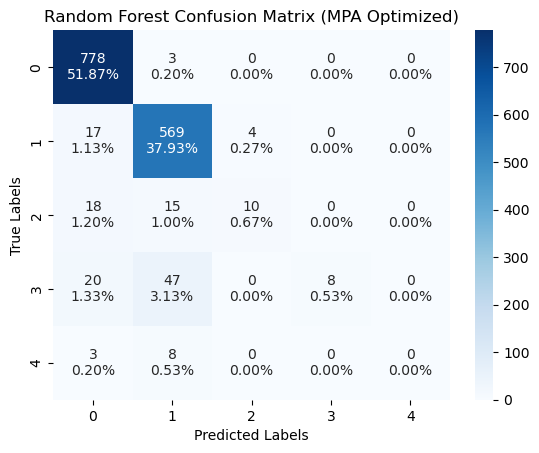

In [7]:
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# === Load Data ===
with open("ECG5000_train.pickle", "rb") as f_train, \
     open("ECG5000_validation.pickle", "rb") as f_val:
    ECGdataset = {
        "train": pickle.load(f_train),
        "val": pickle.load(f_val)
    }

train_data = np.array(ECGdataset["train"])
val_data = np.array(ECGdataset["val"])

X_train_raw = train_data[:, 1:]
y_train = train_data[:, 0]
X_val_raw = val_data[:, 1:]
y_val = val_data[:, 0]

# === Feature Extraction ===
import pywt

def extract_features(X, wavelet='db4', level=3):
    features = []
    for sample in X:
        # Normalize
        sample = StandardScaler().fit_transform(sample.reshape(-1, 1)).flatten()

        # === Statistical features ===
        stats = [
            np.mean(sample),
            np.std(sample),
            np.min(sample),
            np.max(sample),
            skew(sample),
            kurtosis(sample),
            np.median(sample),
            np.percentile(sample, 25),
            np.percentile(sample, 75),
        ]

        # === Wavelet decomposition ===
        coeffs = pywt.wavedec(sample, wavelet=wavelet, level=level)
        wavelet_features = []
        for c in coeffs:
            wavelet_features += [
                np.mean(c), np.std(c), np.linalg.norm(c),  # Energy-like
                skew(c), kurtosis(c)
            ]

        features.append(stats + wavelet_features)
    return np.array(features)


X_train_feat = extract_features(X_train_raw)
X_val_feat = extract_features(X_val_raw)

# Use a stratified subset for hyperparam optimization
X_sub, _, y_sub, _ = train_test_split(X_train_feat, y_train, train_size=0.3, stratify=y_train, random_state=42)

# === Define Fitness Function ===
def rf_fitness(params):
    n_estimators, max_depth = params
    n_estimators = int(np.clip(n_estimators, 10, 200))
    max_depth = int(np.clip(max_depth, 2, 30))

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_sub, y_sub)
    y_pred = clf.predict(X_sub)
    return -accuracy_score(y_sub, y_pred)

# === MPA Optimizer ===
def marine_predator_algorithm(fitness_func, dim, bounds, n_agents=10, max_iter=20):
    lb, ub = np.array(bounds[0]), np.array(bounds[1])
    agents = np.random.uniform(lb, ub, (n_agents, dim))
    fitness = np.array([fitness_func(agent) for agent in agents])

    best_idx = np.argmin(fitness)
    best_pos = agents[best_idx].copy()
    best_score = fitness[best_idx]
    convergence = [best_score]

    for t in range(max_iter):
        r = np.random.rand()
        FADs = 0.2 + 0.1 * np.random.randn(dim)

        for i in range(n_agents):
            P = agents[i].copy()
            if t <= max_iter / 3:
                P += r * (best_pos - r * agents[i])
            elif t <= 2 * max_iter / 3:
                if i > n_agents / 2:
                    P += r * (r * best_pos - agents[i])
                else:
                    P = best_pos + r * (best_pos - agents[i])
            else:
                P = best_pos + FADs * (r * best_pos - agents[i])

            P = np.clip(P, lb, ub)
            score = fitness_func(P)
            if score < fitness[i]:
                agents[i] = P
                fitness[i] = score
                if score < best_score:
                    best_pos = P
                    best_score = score

        convergence.append(best_score)

    return best_pos, -best_score, convergence

# === Run MPA for RF ===
bounds_rf = ([10, 2], [200, 30])
best_params_rf, best_acc_rf, _ = marine_predator_algorithm(
    fitness_func=rf_fitness,
    dim=2,
    bounds=bounds_rf,
    n_agents=10,
    max_iter=20
)
print("Best RF Params [n_estimators, max_depth]:", best_params_rf)
print("Best Subset Accuracy:", best_acc_rf)

# === Final Model Training ===
n_estimators_opt = int(best_params_rf[0])
max_depth_opt = int(best_params_rf[1])

rf_model = RandomForestClassifier(
    n_estimators=n_estimators_opt,
    max_depth=max_depth_opt,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_feat, y_train)
y_val_pred = rf_model.predict(X_val_feat)
y_val_prob = rf_model.predict_proba(X_val_feat)

# === Evaluation ===
accuracy = round(accuracy_score(y_val, y_val_pred), 4)
precision = round(precision_score(y_val, y_val_pred, average='weighted', zero_division=0), 4)
recall = round(recall_score(y_val, y_val_pred, average='weighted'), 4)
f1 = round(f1_score(y_val, y_val_pred, average='weighted'), 4)

# Binarize for AUROC (One-vs-Rest)
from sklearn.preprocessing import label_binarize
classes = np.unique(y_train)
y_val_bin = label_binarize(y_val, classes=classes)
auroc = round(roc_auc_score(y_val_bin, y_val_prob, average='weighted', multi_class='ovr'), 4)

print("Multi-class RF Results:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUROC:", auroc)

# === Confusion Matrix ===
cf_matrix = confusion_matrix(y_val, y_val_pred)
plt.figure(dpi=100)
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(cf_matrix.shape)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Random Forest Confusion Matrix (MPA Optimized)')
plt.show()
